In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
from keras.optimizers import Adam, RMSprop, Nadam, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

### Read data

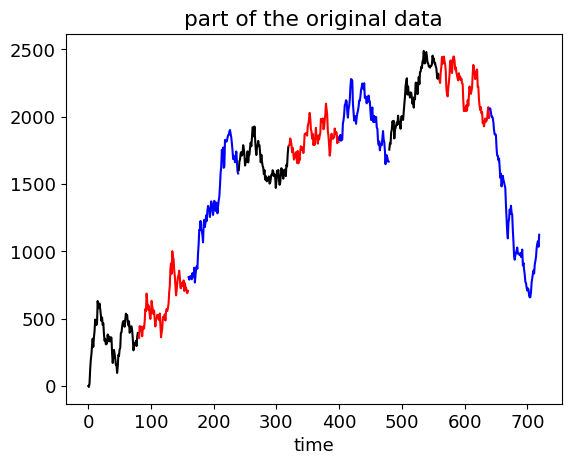

data:  4000


In [97]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

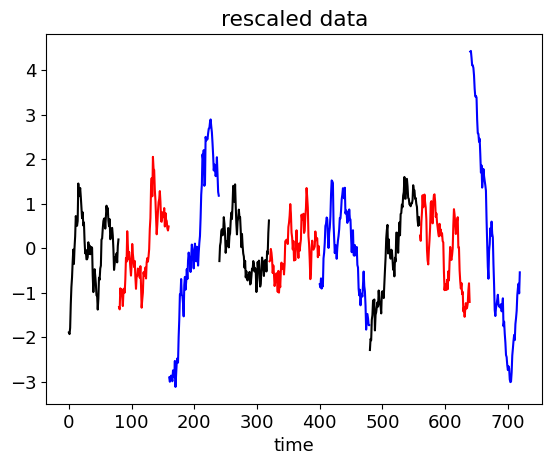

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [98]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [99]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

NCONV=2

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .Adam()
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = keras.optimizers.RMSprop()
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

print(model.layers)

----- Model 2 -----
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_69 (Conv1D)          (None, 70, 5)             60        
                                                                 
 conv1d_70 (Conv1D)          (None, 67, 5)             105       
                                                                 
 conv1d_71 (Conv1D)          (None, 64, 5)             105       
                                                                 
 global_max_pooling1d_23 (G  (None, 5)                 0         
 lobalMaxPooling1D)                                              
                                                                 
 flatten_23 (Flatten)        (None, 5)                 0         
                                                                 
 dense_23 (Dense)            (None, 3)                 18        
                                 

4


TypeError: 'str' object is not callable

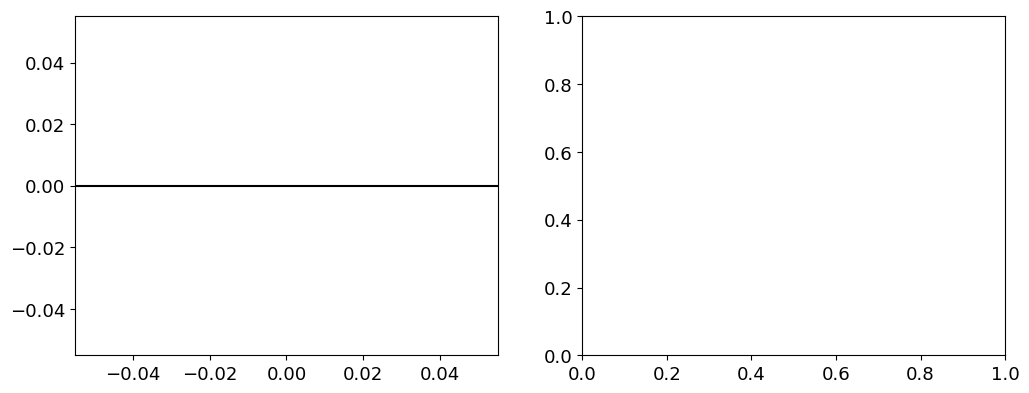

In [112]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    #print(M)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)

    print()
    
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [7]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 
print("end of fit")

----- Model  2 -----
FITTING....
Epoch 1/300


16/16 - 2s - loss: 1.1291 - accuracy: 0.3331 - val_loss: 1.1116 - val_accuracy: 0.3200 - 2s/epoch - 96ms/step
Epoch 2/300
16/16 - 0s - loss: 1.1023 - accuracy: 0.3500 - val_loss: 1.0961 - val_accuracy: 0.3825 - 103ms/epoch - 6ms/step
Epoch 3/300
16/16 - 0s - loss: 1.0907 - accuracy: 0.4256 - val_loss: 1.0866 - val_accuracy: 0.4338 - 101ms/epoch - 6ms/step
Epoch 4/300
16/16 - 0s - loss: 1.0821 - accuracy: 0.4437 - val_loss: 1.0773 - val_accuracy: 0.4425 - 89ms/epoch - 6ms/step
Epoch 5/300
16/16 - 0s - loss: 1.0731 - accuracy: 0.4472 - val_loss: 1.0672 - val_accuracy: 0.4338 - 89ms/epoch - 6ms/step
Epoch 6/300
16/16 - 0s - loss: 1.0624 - accuracy: 0.4525 - val_loss: 1.0551 - val_accuracy: 0.4825 - 93ms/epoch - 6ms/step
Epoch 7/300
16/16 - 0s - loss: 1.0498 - accuracy: 0.4766 - val_loss: 1.0405 - val_accuracy: 0.5100 - 97ms/epoch - 6ms/step
Epoch 8/300
16/16 - 0s - loss: 1.0356 - accuracy: 0.4900 - val_loss: 1.0248 - val_accuracy: 0.5138 - 99

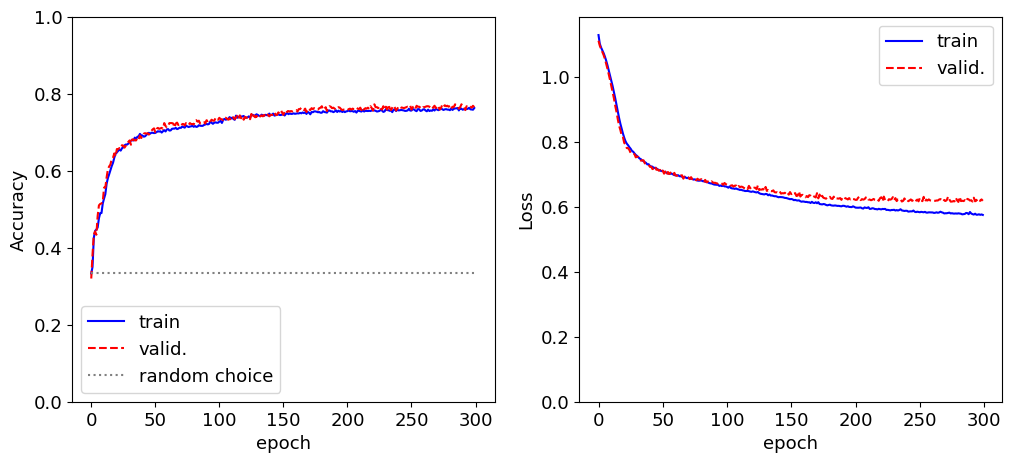

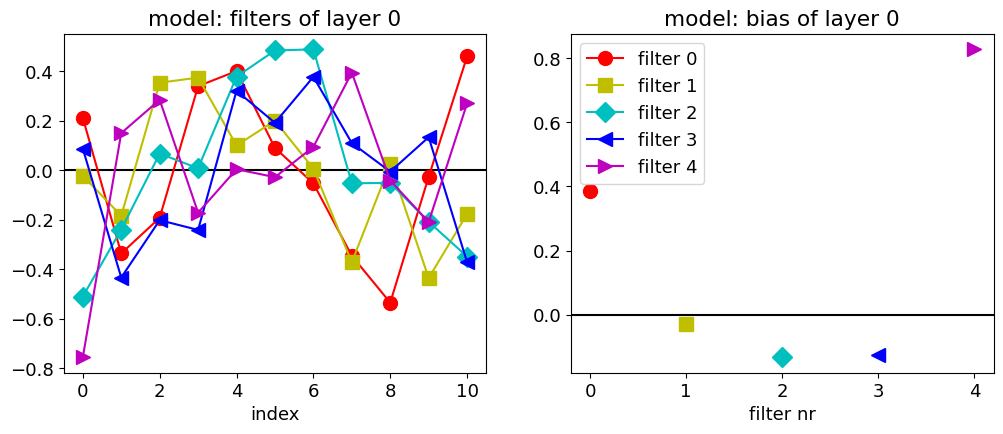

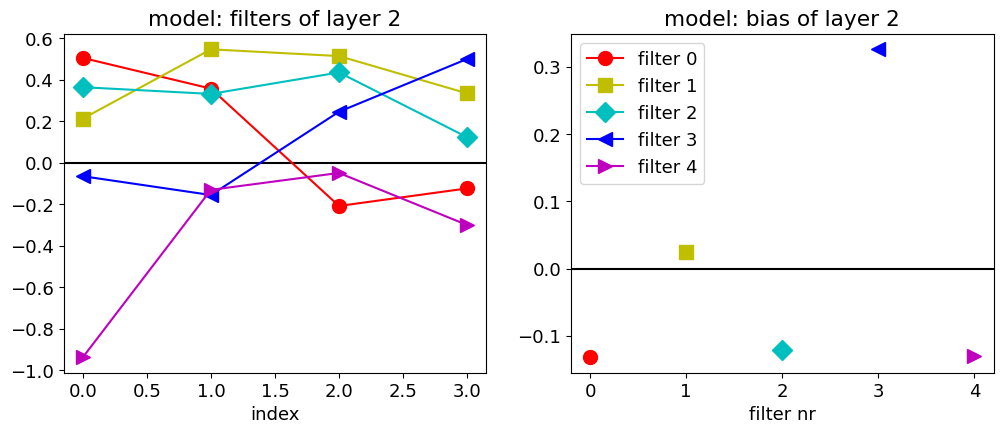

In [8]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

25/25 [==============================] - 0s 3ms/step


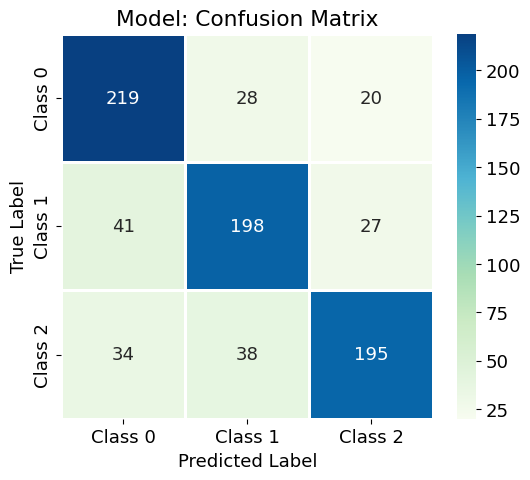

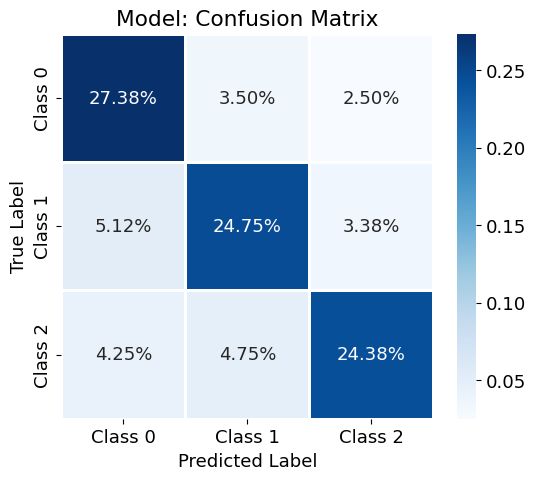

In [9]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = np.array(model.predict(x_val))
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

In [10]:
model2 = keras.models.clone_model(model)

reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2
model2.layers[1].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2

opt = tf.keras.optimizers.legacy.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 200
EPOCHS2 = 300

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

Epoch 1/300
16/16 - 1s - loss: 1.1349 - accuracy: 0.3509 - val_loss: 1.1197 - val_accuracy: 0.3600 - 620ms/epoch - 39ms/step
Epoch 2/300
16/16 - 0s - loss: 1.1101 - accuracy: 0.3391 - val_loss: 1.1038 - val_accuracy: 0.3475 - 83ms/epoch - 5ms/step
Epoch 3/300
16/16 - 0s - loss: 1.1005 - accuracy: 0.3394 - val_loss: 1.0981 - val_accuracy: 0.3512 - 81ms/epoch - 5ms/step
Epoch 4/300
16/16 - 0s - loss: 1.0971 - accuracy: 0.3494 - val_loss: 1.0962 - val_accuracy: 0.3438 - 81ms/epoch - 5ms/step
Epoch 5/300
16/16 - 0s - loss: 1.0952 - accuracy: 0.3516 - val_loss: 1.0948 - val_accuracy: 0.3450 - 84ms/epoch - 5ms/step
Epoch 6/300
16/16 - 0s - loss: 1.0930 - accuracy: 0.3681 - val_loss: 1.0928 - val_accuracy: 0.3413 - 81ms/epoch - 5ms/step
Epoch 7/300
16/16 - 0s - loss: 1.0907 - accuracy: 0.3681 - val_loss: 1.0899 - val_accuracy: 0.3388 - 82ms/epoch - 5ms/step
Epoch 8/300
16/16 - 0s - loss: 1.0872 - accuracy: 0.3847 - val_loss: 1.0852 - val_accuracy: 0.3725 - 83ms/epoch - 5ms/step
Epoch 9/300
16

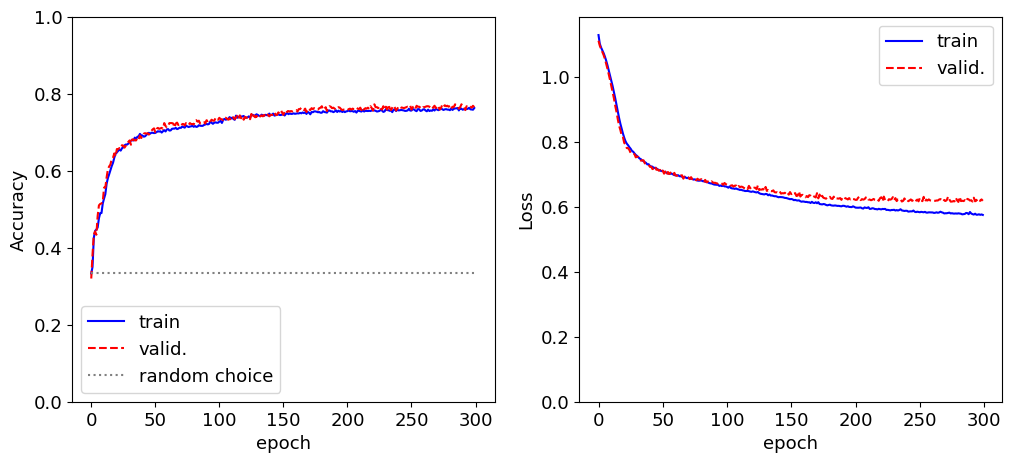

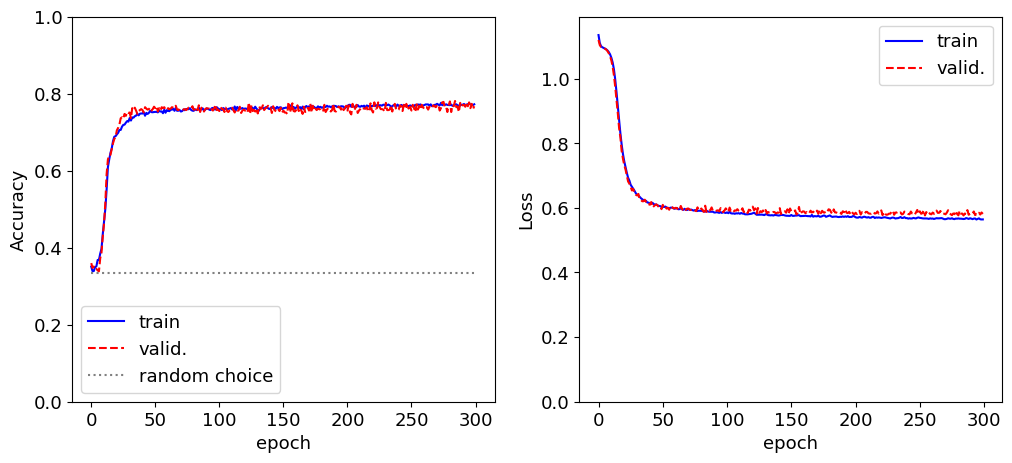

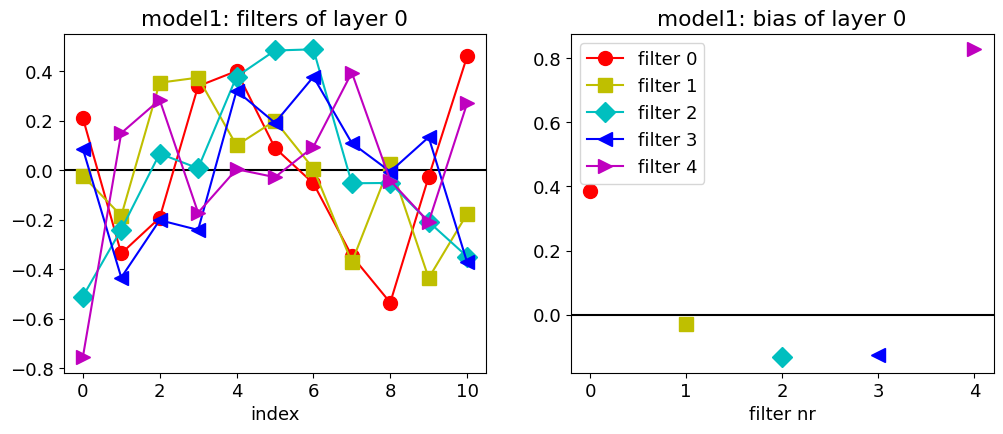

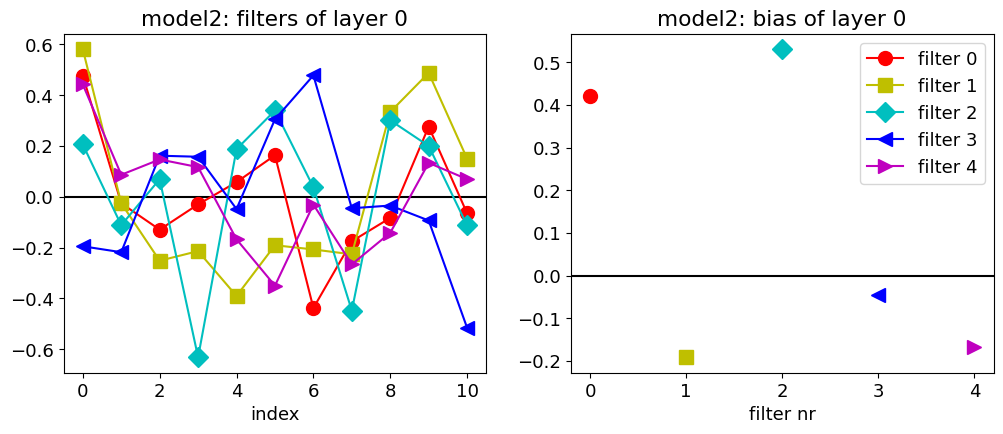

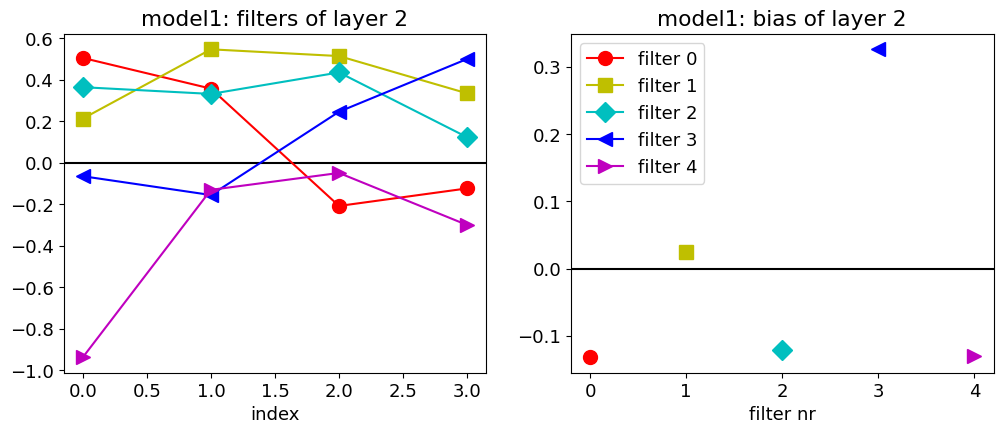

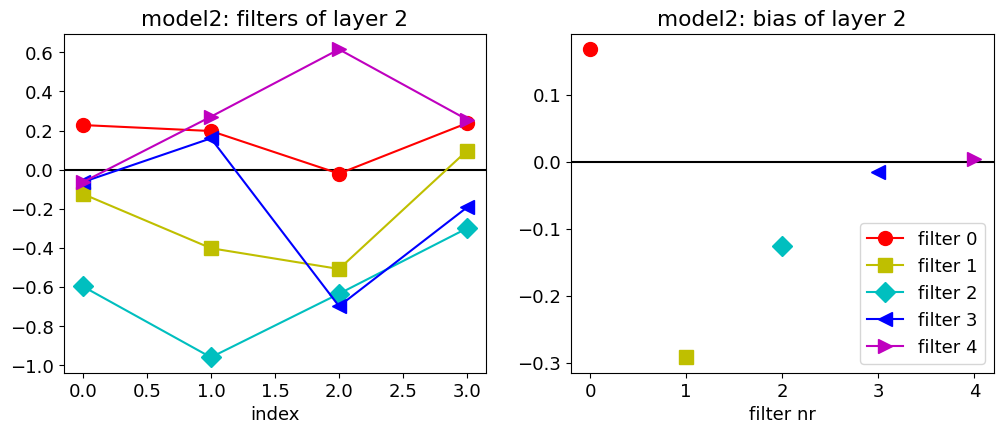

25/25 [==============================] - 0s 3ms/step


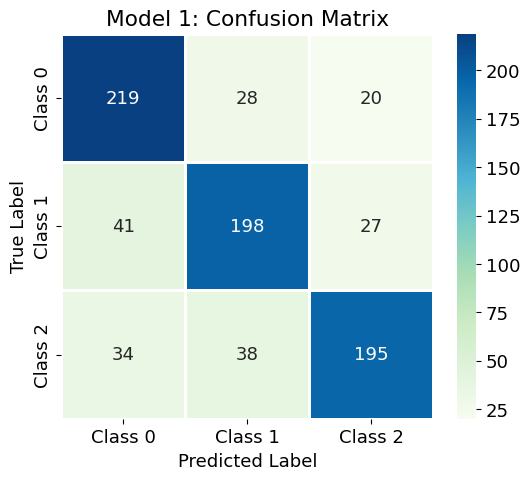

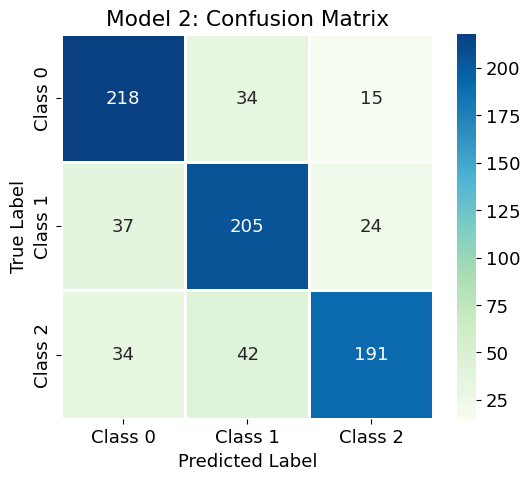

In [11]:

Show_history(fit)
Show_history(fit2)

Show_weights(model,0,label="model1")
Show_weights(model2,0,label="model2")
Show_weights(model,2,label="model1")
Show_weights(model2,2,label="model2")


y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1")
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")

# Solution 1.

As regard to the first point of the exercises, on the basis of the obtained results we chose the CNN version ending with a global max pooling layer (G). It can indeed be observed, from the available plots of training and validation errors through the $300$ epochs, that overfitting appears to occur with and without regularization. For the G version, instead, the training and validation accuracies are very similar, and the regularization term introduces smoothing of the relative curves.

# Solution 2.

In [12]:
def plot_models(opts):
    
    N_fits = 5
    
    for o in opts:
        for _ in range(N_fits):
            
            model=build_model(NCONV=2,KS=11)
            model.compile(loss=keras.losses.categorical_crossentropy, optimizer = o, metrics = ['accuracy'])
    
            BATCH_SIZE = 200
            EPOCHS = 50
    
            fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=1, shuffle=True)
    
            Show_history(fit)

OPTIMIZER:  ADAM
Learning rate: 0.00050 (Run: 1)
---------------------------------------
Iteration number:  1 of 100
Remaining time:  41.34 min
Learning rate: 0.00050 (Run: 2)
---------------------------------------
Iteration number:  2 of 100
Remaining time:  40.93 min
Learning rate: 0.00050 (Run: 3)
---------------------------------------
Iteration number:  3 of 100
Remaining time:  40.50 min
Learning rate: 0.00050 (Run: 4)
---------------------------------------
Iteration number:  4 of 100
Remaining time:  40.08 min
Learning rate: 0.00050 (Run: 5)
---------------------------------------
Iteration number:  5 of 100
Remaining time:  39.67 min
Validation accuracy and std:  [[0.6955000042915345, 0.08309857700124726]]
Learning rate: 0.00287 (Run: 1)
---------------------------------------
Iteration number:  6 of 100
Remaining time:  39.27 min
Learning rate: 0.00287 (Run: 2)
---------------------------------------
Iteration number:  7 of 100
Remaining time:  38.85 min
Learning rate: 0.002

<Figure size 2000x500 with 0 Axes>

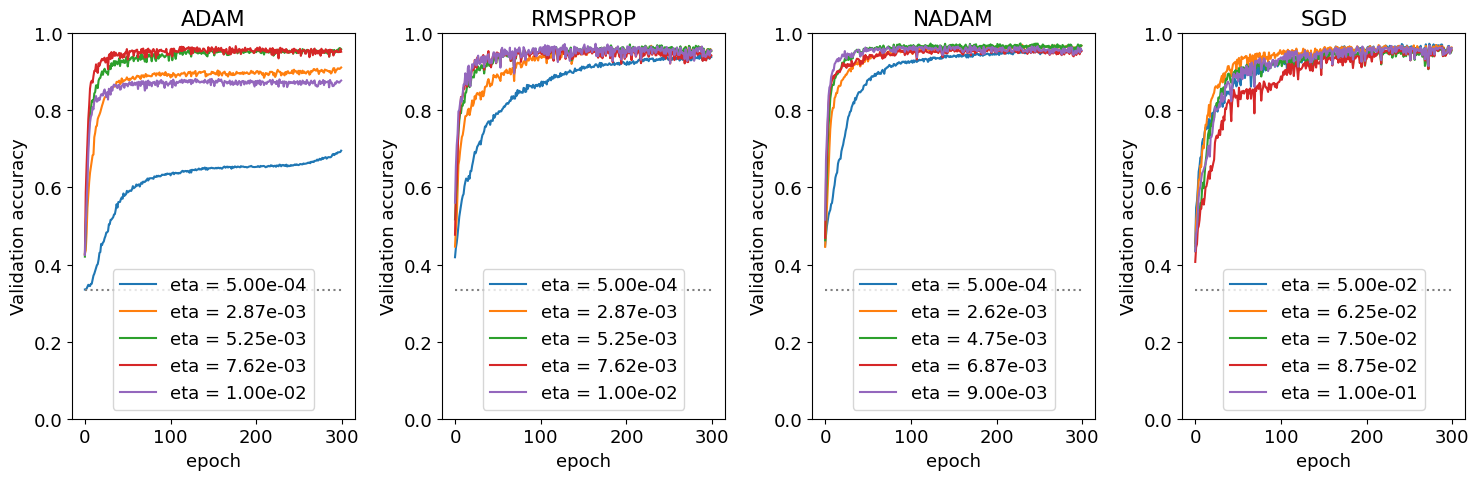

In [55]:
import time 

def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 5
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.01, 5), np.linspace(0.0005, 0.01, 5), np.linspace(0.0005, 0.009, 5), np.linspace(0.05, 0.1, 5)] #imposto questo valore per ora 

ACCURACY = {}

num_iter = len(OPTIMIZERS) * 5 * len(etas_tot[0])
counter = 1

start = time.time()
count_time = 0

for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    ax = fig.add_subplot(1, 4, j + 1)
    
    ACCURACY[opt_] = []

    
    for k, e in enumerate(etas_tot[j]):
        
        mean = 0
        STD = []
        
        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
            #val_accuracy_eta += fit.history['val_accuracy']
            

            print('---------------------------------------')
            print('Iteration number: ', counter, 'of', num_iter )

            mean += fit.history['val_accuracy'][-1]
            STD.append(fit.history['val_accuracy'][-1])

            counter += 1
            
            if count_time == 0:

               stop = time.time() 
               total_time = stop - start 
               
               count_time += 1
            
            vu =( total_time * 100 - 2 * ( time.time() - start )  ) / 60

            print(f'Remaining time:  {vu:.2f} min')


        ACCURACY[opt_].append([mean / N_run, np.std(STD)])
        
            
        print('Validation accuracy and std: ', ACCURACY[opt_])
    
        val_tot = [v / N_run for v in val_tot]

        ax.plot(val_tot,label=f"eta = {e:.2e}")
    


    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
    ax.set_title(opt_.upper())
    ax.set_xlabel('epoch')
    ax.set_ylabel("Validation accuracy")
    ax.set_ylim([0, 1])
    ax.legend()

plt.tight_layout()
plt.show()

{'adam': [[0.6955000042915345, 0.08309857700124726], [0.772249984741211, 0.005722765487311396], [0.7764999866485596, 0.009823451400138135], [0.7605000019073487, 0.01359228245498733], [0.6869999885559082, 0.17678835175012458]], 'rmsprop': [[0.7629999995231629, 0.013290027464522703], [0.7679999947547913, 0.007441436142761509], [0.7625, 0.0064710764732883], [0.7519999980926514, 0.014675660340763372], [0.7674999952316284, 0.0045414646378209795]], 'nadam': [[0.7639999985694885, 0.019127847098072952], [0.7767500042915344, 0.005338534034788004], [0.7747499823570252, 0.0029999901851174523], [0.7599999904632568, 0.008767833995781796], [0.765500009059906, 0.009171977612846783]], 'sgd': [[0.7704999923706055, 0.00691917955949209], [0.7710000038146972, 0.0080389717920162], [0.7617499947547912, 0.022480558054178677], [0.7662500143051147, 0.01594913951472209], [0.7705000042915344, 0.008895233716283186]]}


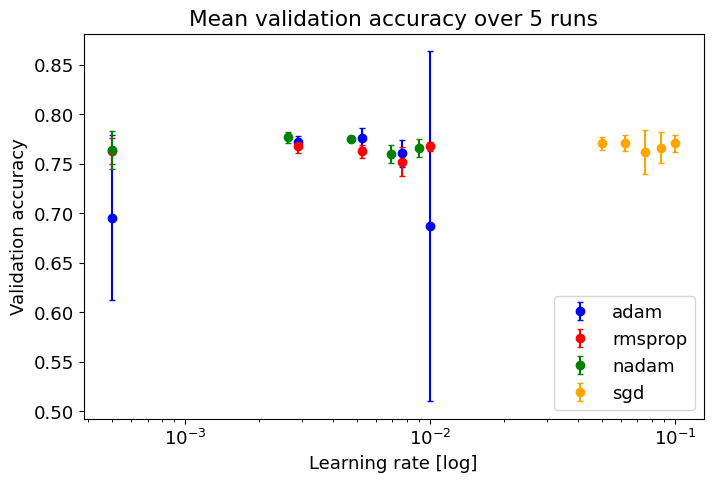

In [57]:
#inserire grafico 

index = np.linspace(1, 20, 20)

colors = ['blue', 'red', 'green', 'orange']

figure = plt.figure(figsize = (8, 5))

ax = figure.add_subplot(111)
t = 1

print(ACCURACY)

for k, i in enumerate(ACCURACY):
    element = ACCURACY[i]
    eta = etas_tot[k]
    
    ax.errorbar(eta[0], element[0][0], yerr = element[0][1], c = colors[k], label = OPTIMIZERS[k], capsize = 2, fmt = 'o')

    for j in range(1, len(eta)):
       
       ax.errorbar(eta[j], element[j][0], yerr = element[j][1], c = colors[k], capsize = 2, fmt = 'o')

       t += 1



ax.set_title("Mean validation accuracy over 5 runs")
ax.set_xlabel('Learning rate [log]')
ax.set_ylabel("Validation accuracy")
ax.legend()
ax.set_xscale('log')
plt.show()


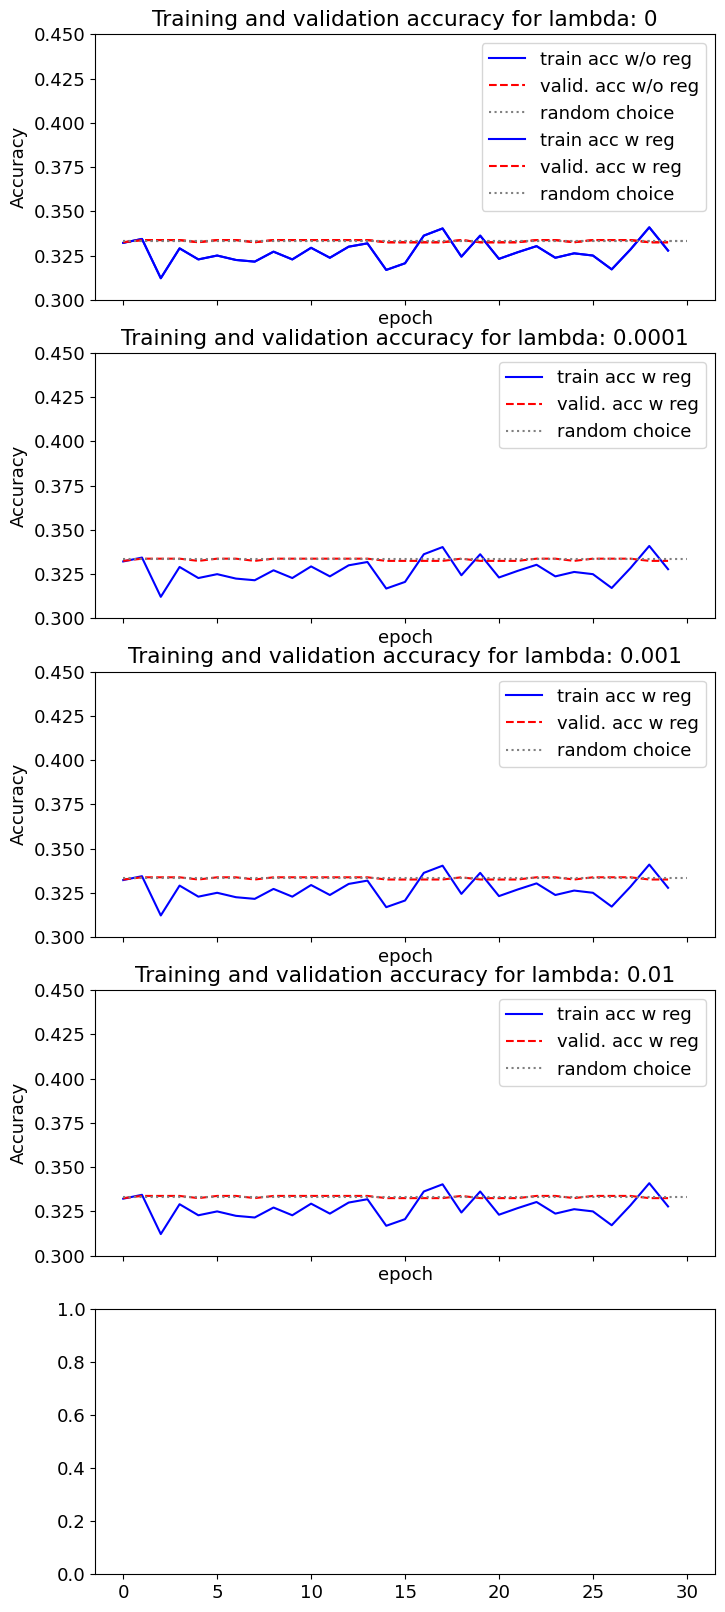

In [115]:

#Introducing the regularization 

best_lr = 4.75e-3 #inserire ad hoc valore-



lamb = [0, 10e-5, 10e-4, 10e-3]

BATCH_SIZE = 20
EPOCHS = 30

figure, axes = plt.subplots(len(lamb) + 1, 1, figsize = (8, 5 * len(lamb)), sharex = True )

model2 = keras.models.clone_model(model)
opt2 = get_optimizer('nadam', learning_rate=best_lr)
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt2, metrics = ['accuracy'])
fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)

ax = axes[0]

ax.plot(fit2.history['accuracy'],"b",label="train acc w/o reg")
ax.plot(fit2.history['val_accuracy'],"r--",label="valid. acc w/o reg")
ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")

ax.set_title(f"Training and validation accuracy")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.set_ylim([0.3, 0.45])
ax.legend()

LAMBDA = {}

for k, i in enumerate(lamb):
    LAMBDA[(i)] = []

    reg2 = keras.regularizers.l2(i)
    model2.layers[0].kernel_regularizer = reg2
    model2.layers[1].kernel_regularizer = reg2
    model2.layers[2].kernel_regularizer = reg2
    
    ax = axes[k + 1] if len(lamb) > 1 else axes

    ax.plot(fit2.history['accuracy'],"b",label="train acc w reg")
    ax.plot(fit2.history['val_accuracy'],"r--",label="valid. acc w reg")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")

    ax.set_title(f"Training and validation accuracy for lambda: {i}")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0.3, 0.45])
    ax.legend()

    LAMBDA[(i)].append([fit2.history['accuracy'][-1], fit2.history['val_accuracy'][-1]])
   
plt.show()
   


Selected the best value for lambda we can proceed varying KS and NF.

In [116]:

val_acc_lamb = [LAMBDA[i][0][1] for i in lamb]

best_lamb = np.min(val_acc_lamb)

print(f'Best value for the regularization parameter:  {best_lamb:.4f}')


Best value for the regularization parameter:  0.3325


4


TypeError: 'str' object is not callable

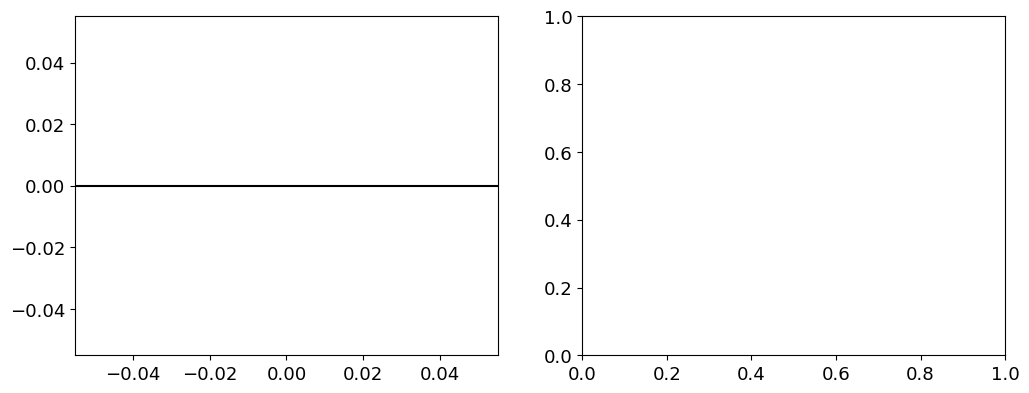

In [117]:
KS = [ 10, 11, 12 ] #kernel size
NF = [ 4, 5, 6 ] #number filters

for i in NF:
    for j in KS:

       model = build_model(NCONV = 2, NF = i, KS = j)
       opt3 = get_optimizer('nadam', learning_rate=best_lr)

       reg2 = keras.regularizers.l2(best_lamb)
       model.layers[0].kernel_regularizer = reg2
       model.layers[1].kernel_regularizer = reg2
       model.layers[2].kernel_regularizer = reg2

       model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])
       
       Show_weights(model,0)
       Show_weights(model,2)



OPTIMIZER:  RMSPROP
Learning rate: 0.00050 (Run: 1)
Learning rate: 0.00287 (Run: 1)
Learning rate: 0.00525 (Run: 1)
Learning rate: 0.00762 (Run: 1)
Learning rate: 0.01000 (Run: 1)


<Figure size 2000x500 with 0 Axes>

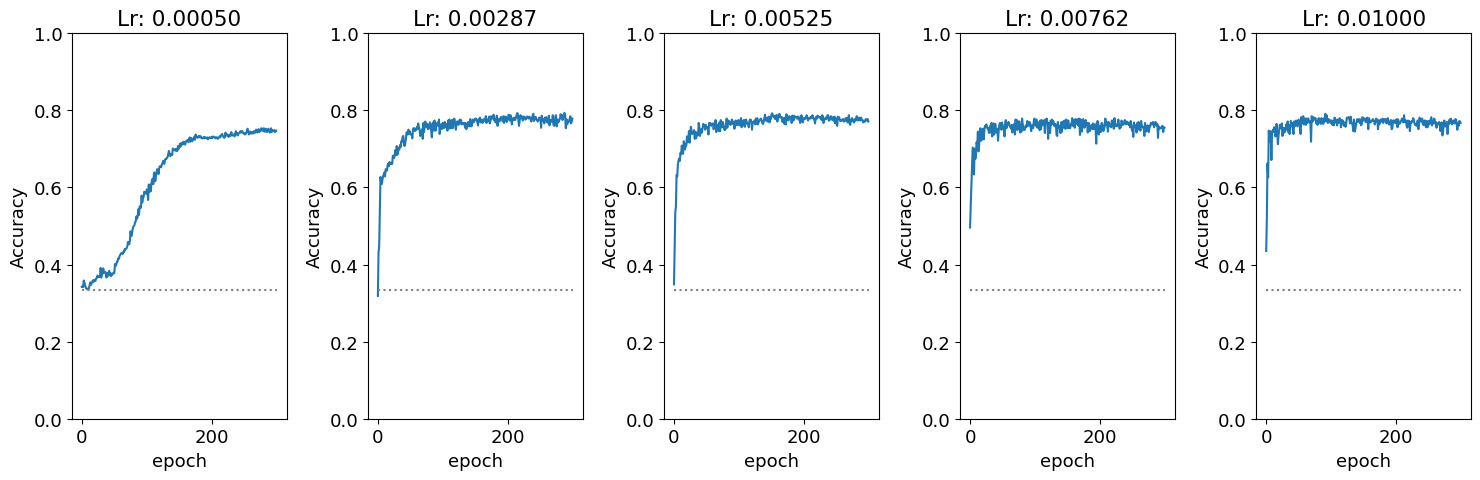

In [33]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['rmsprop']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 1
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.01, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        val_tot = [v / N_run for v in val_tot]

       
    
        
        #ax.legend()

plt.tight_layout()
plt.show()

OPTIMIZER:  ADAM
Learning rate: 0.00050 (Run: 1)
Learning rate: 0.00287 (Run: 1)
Learning rate: 0.00525 (Run: 1)
Learning rate: 0.00762 (Run: 1)
Learning rate: 0.01000 (Run: 1)


<Figure size 2000x500 with 0 Axes>

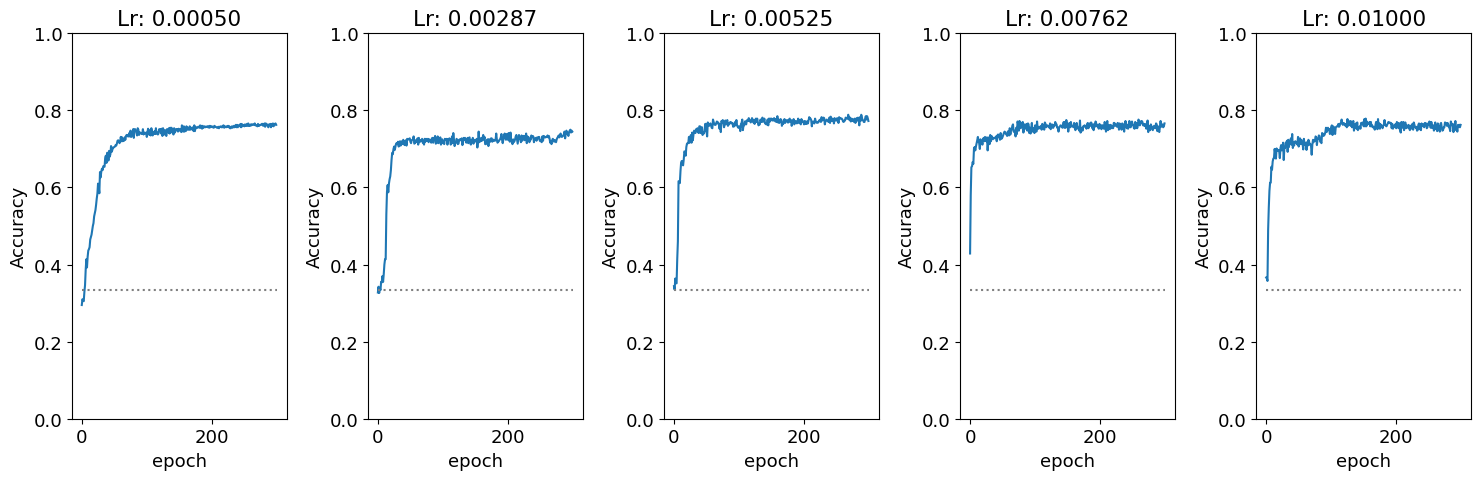

In [36]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['adam']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 1
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.01, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        val_tot = [v / N_run for v in val_tot]

       
    
        
        #ax.legend()

plt.tight_layout()
plt.show()

OPTIMIZER:  NADAM
Learning rate: 0.00050 (Run: 1)
Learning rate: 0.00262 (Run: 1)
Learning rate: 0.00475 (Run: 1)
Learning rate: 0.00687 (Run: 1)
Learning rate: 0.00900 (Run: 1)


<Figure size 2000x500 with 0 Axes>

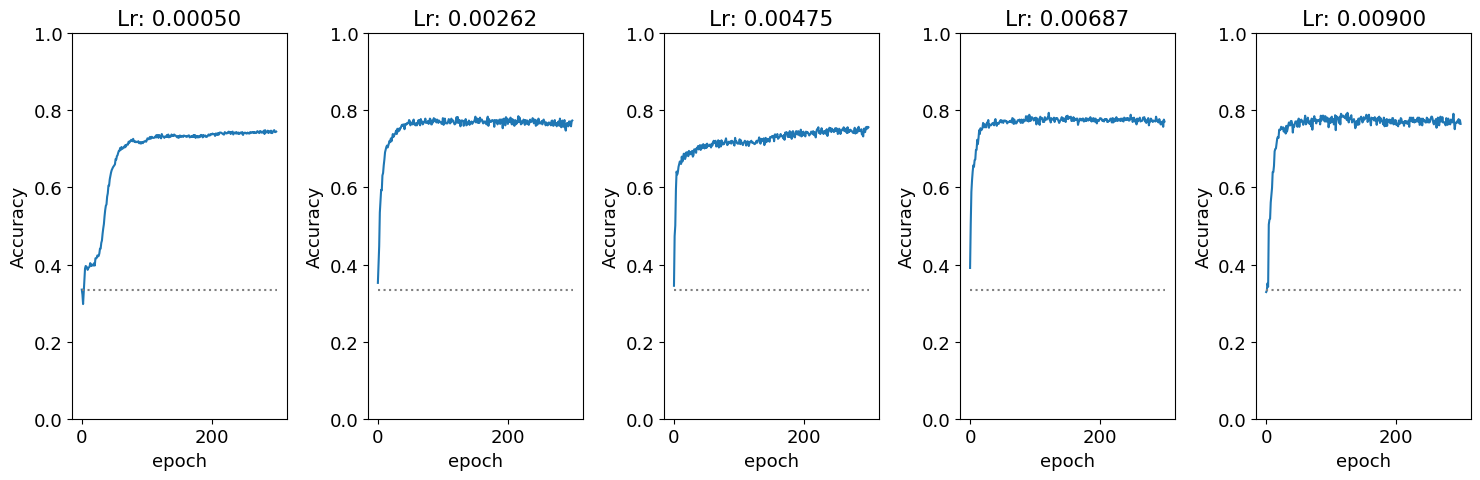

In [40]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['nadam']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 1
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.009, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        val_tot = [v / N_run for v in val_tot]

       
    
        
        #ax.legend()

plt.tight_layout()
plt.show()

OPTIMIZER:  SGD
Learning rate: 0.05000 (Run: 1)
Learning rate: 0.05000 (Run: 2)
Learning rate: 0.05000 (Run: 3)
Learning rate: 0.05000 (Run: 4)
Learning rate: 0.05000 (Run: 5)
Learning rate: 0.06250 (Run: 1)
Learning rate: 0.06250 (Run: 2)
Learning rate: 0.06250 (Run: 3)
Learning rate: 0.06250 (Run: 4)
Learning rate: 0.06250 (Run: 5)
Learning rate: 0.07500 (Run: 1)
Learning rate: 0.07500 (Run: 2)
Learning rate: 0.07500 (Run: 3)
Learning rate: 0.07500 (Run: 4)
Learning rate: 0.07500 (Run: 5)
Learning rate: 0.08750 (Run: 1)
Learning rate: 0.08750 (Run: 2)
Learning rate: 0.08750 (Run: 3)
Learning rate: 0.08750 (Run: 4)
Learning rate: 0.08750 (Run: 5)
Learning rate: 0.10000 (Run: 1)
Learning rate: 0.10000 (Run: 2)
Learning rate: 0.10000 (Run: 3)
Learning rate: 0.10000 (Run: 4)
Learning rate: 0.10000 (Run: 5)


<Figure size 2000x500 with 0 Axes>

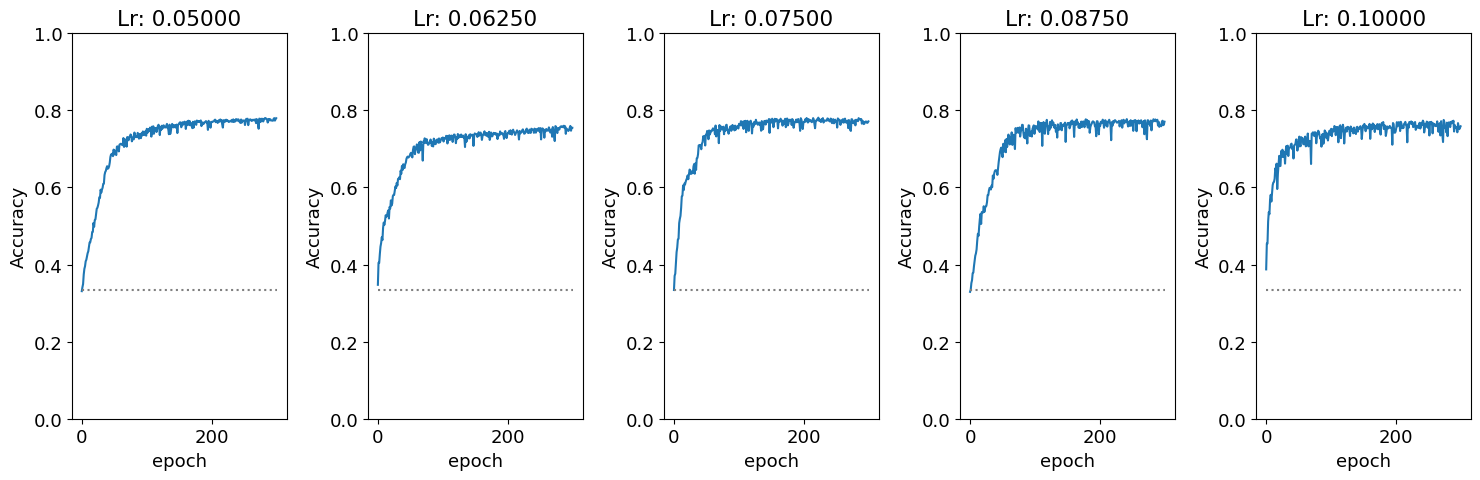

In [37]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['sgd']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 5
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.05, 0.1, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
        
        val_tot = [v / N_run for v in val_tot]
        
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        

       
    
        
        #ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2